In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Tensorflow imports

# for building model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Flatten, GlobalMaxPooling1D, Dense, Dropout
from keras.initializers import Constant

# for Padding
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for Tokenization 
from tensorflow.keras.preprocessing.text import Tokenizer

# NLTK imports
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For visualization
import matplotlib.pyplot as plt
# import seaborn as sns

# For regular expressions
import re

# For data preprocessing
from string import punctuation, digits

# loading progress
import tqdm

In [2]:
# Read in data
train_df = pd.read_csv('dataset/Corona_NLP_train.csv', encoding="Latin-1")
test_df = pd.read_csv('dataset/Corona_NLP_test.csv', encoding="Latin-1")

print(f"train dataset shape >> {train_df.shape}")
print(f"test dataset shape >> {test_df.shape}")

train dataset shape >> (41157, 6)
test dataset shape >> (3798, 6)


In [9]:
print(train_df['ScreenName'][0])

KeyError: '44953'

In [6]:
# Creat new dataset (which will consist from 2 columns: label, data)

def data_label_split(dataset):
    data = dataset['OriginalTweet']
    label = dataset['Sentiment']
    return data,label

train_data,train_label = data_label_split(train_df)
test_data,test_label = data_label_split(test_df)

train = pd.DataFrame({
    'label':train_label,
    'data':train_data
})

test = pd.DataFrame({
    'label':test_label,
    'data':test_data
})

# Define function which will make new labels

def reassign_label(x):
    if x == "Extremely Positive" or x == "Positive":
        return 1
    elif x =="Extremely Negative" or x =="Negative":
        return -1
    elif x =="Neutral":
        return 0

train.label = train.label.apply(lambda x:reassign_label(x))
test.label = test.label.apply(lambda x:reassign_label(x))

train

,label,data
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,1,advice Talk to your neighbours family to excha...
2,1,Coronavirus Australia: Woolworths to give elde...
3,1,My food stock is not the only one which is emp...
4,-1,"Me, ready to go at supermarket during the #COV..."
...,...,...
41152,0,Airline pilots offering to stock supermarket s...
41153,-1,Response to complaint not provided citing COVI...
41154,1,You know itÂs getting tough when @KameronWild...
41155,0,Is it wrong that the smell of hand sanitizer i...


## Data preprocessing

In [7]:
def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s.lower()

def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', '', sentence) # remove URL adresses
    sentence = re.sub(r"\@(\w+)", '', sentence) # remove usernames
    sentence = re.sub(r"\#(\w+)", '', sentence) # remove hashtags
    sentence = re.sub(r"\$(\w+)", '', sentence) # remove cashtags
    sentence = sentence.replace("-",' ')
    tokens = sentence.split()
    tokens = [remove_punctuation(w) for w in tokens] # remove punctuations
    stop_words = set(stopwords.words('english')) # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]
    remove_digits = str.maketrans('', '', digits)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    return tokens

def process_text(text):
  text = str(text) #Convert string to str
  #Lowers the string
  text = text.lower()
  #Removes the full url
  url_remove = re.compile(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  text = re.sub(url_remove,' ',text)
  #Removes the punctuation
  text = ''.join([string for string in text if string not in punctuation and not string.isdigit()])
  #Removes any more special characters
  special_character = re.compile(r'[^a-zA-Z]')
  text = re.sub(special_character,' ', text)
  text = text.strip() #Strip white spaces
  text = text.split(' ')
  text = ' '.join([string for string in text if string not in stopwords.words('english')])#Removing all stop words
  return text

In [8]:
# Clean sentences in train and test data
train.data = train.data.apply(lambda sentence:clean_sentence(sentence))
test.data = test.data.apply(lambda sentence:clean_sentence(sentence))

#train.data = train.data.apply(process_text)
#test.data = test.data.apply(process_text)

In [23]:
train

,label,data
0,0,
1,1,advice talk neighbours family exchange phone n...
2,1,coronavirus australia woolworths give elderly ...
3,1,food stock one empty please dont panic enough ...
4,-1,ready go supermarket outbreak im paranoid food...
...,...,...
41152,0,airline pilots offering stock supermarket shel...
41153,-1,response complaint provided citing covid relat...
41154,1,know itâs getting tough rationing toilet pape...
41155,0,wrong smell hand sanitizer starting turn


In [9]:
# Splitting data to train and test

# Train data
train_data = train.data
train_label = train.label

# Test data
test_data = test.data
test_label = test.label

In [10]:
# Convert categorical variable (in our case: -1, 0, 1) into dummy/indicator variables. Such as -1 to 1 0 0 
train_label = pd.get_dummies(train_label)
test_label = pd.get_dummies(test_label)

## Lemmatization

In [11]:
lemmatizer = WordNetLemmatizer()

# Function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function below is necessery to find lemma of each word
def lemmatize_sentence(de_punct_sent):
    # Tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(de_punct_sent))
    # Tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # If there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [12]:
# Lemmatization of train and test data
train_lem = [lemmatize_sentence(i) for i in train_data]
test_lem = [lemmatize_sentence(i) for i in test_data]

In [28]:
train_lem

['',
 'advice talk neighbours family exchange phone number create contact list phone number neighbour school employer chemist gp set online shop account poss adequate supply regular med order',
 'coronavirus australia woolworths give elderly disable dedicate shopping hour amid covid outbreak',
 'food stock one empty please dont panic enough food everyone take need stay calm stay safe',
 'ready go supermarket outbreak im paranoid food stock litteraly empty serious thing please dont panic cause shortage',
 'news regionâ\x92s first confirm covid case come sullivan county last week people flock area store purchase clean supply hand sanitizer food toilet paper good report',
 'cashier grocery store share insight prove credibility comment im civics class know im talk',
 'supermarket today didnt buy toilet paper',
 'due covid retail store classroom atlanta open walk business class next two week begin monday march continue process online phone order normal thank understanding',
 'corona prevent

## Tokenization

In [13]:
samples_1 = train_lem
samples_2 = test_lem

tokenizer = Tokenizer(num_words=25000) # 25 000 most frequently used words
tokenizer.fit_on_texts(samples_1) # Creat an index of all words from training data

# Convert strings to integer index lists

# After that, we pass the ready-made (from the line above) indexes for all words from train
train_data = tokenizer.texts_to_sequences(samples_1)

# And for test. So, we should get the same word indexes in the two texts
test_data = tokenizer.texts_to_sequences(samples_2)

word_index = tokenizer.word_index # Find out the calculated index of words
print('Found %s unique tokens.' % len(word_index))

Found 32459 unique tokens.


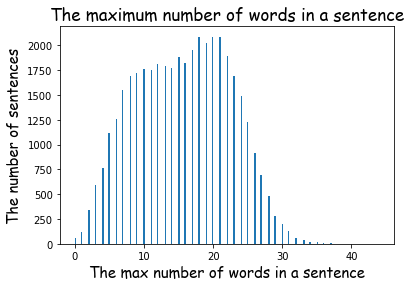

In [14]:
# Now we want to find out what is the maximum number of words in a sentence. 
# After that, we will fill in the sentences with the missing number of words.

lens =  [len(s) for s in train_data]

plt.title('The maximum number of words in a sentence', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 17})
plt.xlabel('The max number of words in a sentence', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.ylabel('The number of sentences', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.hist(lens,bins=200)
plt.show()

In [15]:
maxlen = 40 # maximal length of sentences

# Convert lists of integers to a two-dimensional tensor 
# with integers and with a shape (samples, max. length)

train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen, padding='post', truncating='post') 
test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen, padding='post', truncating='post')


In [2]:
import tqdm
import requests
import zipfile
import os
URLs = ["http://nlp.stanford.edu/data/glove.42B.300d.zip", "https://nlp.stanford.edu/data/glove.6B.zip"]
GLOVES = ['glove.6B.100d.txt', 'glove.42B.300d.txt']

def fetch_data(url, target_file=os.path.join('embeddings','glove.zip'), delete_zip=True):
    current_directory = os.getcwd()
    if not os.path.isdir(os.path.join(current_directory, "embeddings")):
        os.mkdir(os.path.join(current_directory, "embeddings"))
    
    if os.path.isfile(target_file):
        print("datasets already downloded :) ")
    else:
        response = requests.get(url, stream=True)
        #read chunk by chunk
        handle = open(target_file, "wb")
        for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
            if chunk:  
                handle.write(chunk)
        handle.close()  
        print("  Download completed ;) :") 
    
    #extract zip_file
    with zipfile.ZipFile(target_file, 'r') as zip_ref:
        for zipinfo in zip_ref.infolist():
            print("1. Extracting {} file".format(target_file))
            if (os.path.isfile(os.path.join('embeddings', zipinfo.filename))):
                continue
            zip_ref.extract(zipinfo, "embeddings")
    
    if delete_zip:
        print("2. Deleting {} file".format(target_file))
        os.remove(path=target_file)

## ------------------------------------------------------------------------------- ##        
## if word embeddings need to be downloaded just uncomment all the following lines ##
## ------------------------------------------------------------------------------- ##        

# fetch_data("https://nlp.stanford.edu/data/glove.6B.zip")
# fetch_data("http://nlp.stanford.edu/data/glove.42B.300d.zip")


3667580it [05:55, 10314.26it/s]


  Download completed ;) :
1. Extracting embeddings\glove.zip file
2. Deleting embeddings\glove.zip file


## Code for various word embeddings

In [47]:
glove_file = "embeddings/glove.6B.100d.txt"


EMBEDDING_VECTOR_LENGTH = 32 # <=200
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                if word == "comfortable":
                    print(i, vect[:EMBEDDING_VECTOR_LENGTH])
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix

embedding_matrix =  construct_embedding_matrix(glove_file, word_index)
print(embedding_matrix.shape)

100%|██████████| 32459/32459 [00:00<00:00, 1121145.28it/s]

4066 [-3.3853e-01  2.5140e-01  8.2320e-01  2.3253e-01 -2.6978e-01  5.8880e-01
 -1.5392e-01  4.9655e-01 -3.2095e-01  1.0857e-03  1.2539e-01 -3.6712e-01
 -1.8947e-01 -2.0142e-01  4.0242e-01 -6.6370e-01 -6.5111e-01  1.5895e-01
  5.8300e-01  1.9305e-02  3.4783e-01  1.0967e+00  3.9559e-01 -7.9625e-01
 -2.0150e-01 -5.0683e-01 -1.8453e-01 -8.0906e-01  1.0429e-03 -3.4185e-01
 -3.1519e-01  3.0170e-01]
(32460, 32)


In [59]:
# Define some parameters for the model
embedding_dim = 32 # Dimension of the dense embedding.

vocab_inp_size = len(word_index) + 1 # Size of the vocabulary

hidden_size = 256

## Building Classification Model

In [77]:
model = Sequential() 

# The Embedding layer is necessery in order to convert words (in out case from integers) to vectors
model.add(Embedding(input_dim = vocab_inp_size, output_dim = embedding_dim, input_length = maxlen, embeddings_initializer=Constant(embedding_matrix)))
# model.add(Embedding(input_dim = vocab_inp_size, output_dim = embedding_dim, input_length = maxlen))

# Apply Dropout to use recurrent decimation to combat overfitting 
model.add(LSTM(hidden_size, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)) 

# Use Flatten() or GlobalMaxPooling1D() to convert 3D output to 2D.
# It allows you to add one or more Dense layers to your model 
model.add(Flatten()) # or model.add(GlobalMaxPooling1D())

#model.add(Dense(64, activation='relu'))#as experiment we tried to add one additional layer,but it is not give as higher accuracy
#model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))#activation function for classification

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['categorical_accuracy']) 

# access the embedding layer through the constructed model 
# first `0` refers to the position of embedding layer in the `model`
embeddings = model.layers[0].get_weights()[0]

# `embeddings` has a shape of (num_vocab, embedding_dim) 

# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
words_embeddings = {w:embeddings[idx] for w, idx in word_index.items()}

# now you can use it like this for example
# print("covid", words_embeddings['whethe'])  # possible output: [0.21, 0.56, ..., 0.65, 0.10]

history = model.fit(train_data, train_label, epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 40, 32)            1038720   
                                                                 
 lstm_11 (LSTM)              (None, 40, 256)           295936    
                                                                 
 flatten_11 (Flatten)        (None, 10240)             0         
                                                                 
 dense_11 (Dense)            (None, 3)                 30723     
                                                                 
Total params: 1,365,379
Trainable params: 1,365,379
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
258/258 [==============================] - 34s 128ms/step - loss: 0.5200 - categorical_accuracy: 0.6022 - val_loss: 0.4762 - val_categorical_accuracy: 0.6551
Epoch 

In [52]:
# play around with word embedding

# access the embedding layer through the constructed model 
# first `0` refers to the position of embedding layer in the `model`
embeddings = model.layers[0].get_weights()[0]

# `embeddings` has a shape of (num_vocab, embedding_dim) 

# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
words_embeddings = {w:embeddings[idx] for w, idx in word_index.items()}

# now you can use it like this for example
print(words_embeddings['covid'])  # possible output: [0.21, 0.56, ..., 0.65, 0.10]

[ 0.00689689 -0.00532722  0.0330309  -0.01697537 -0.00218005  0.015901
 -0.00199543  0.00719621 -0.01868744  0.01947289 -0.06286783 -0.03776637
  0.041288    0.01977303  0.01580706  0.02267037  0.01076799 -0.02416215
  0.01365873  0.02478311  0.01147822 -0.00284684  0.05994218  0.00926603
  0.00593322  0.03666606 -0.00778103  0.00378901  0.02020696 -0.04372323
  0.01861647 -0.05166999]


## Visualization of model training

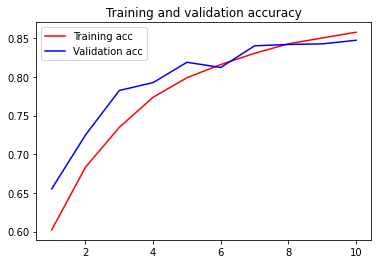

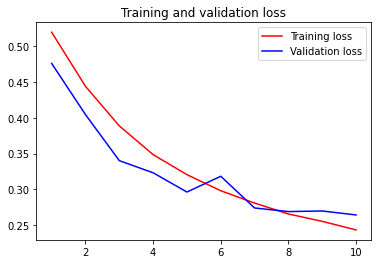

In [78]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model Evaluation

In [79]:
model.evaluate(test_data,test_label)

119/119 [==============================] - 2s 15ms/step - loss: 0.2900 - categorical_accuracy: 0.8289


[0.28995707631111145, 0.8288573026657104]